In [1]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from datetime import date
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn import linear_model
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.api import VAR
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ParameterGrid
import numpy as np
import seaborn as sns
import warnings
from sklearn.pipeline import make_pipeline
from sklearn.kernel_ridge import KernelRidge
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_friedman2
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import SGDRegressor
import statsmodels.api as sm
import itertools
import pmdarima as pm
from sklearn.pipeline import make_pipeline
from pmdarima.arima import auto_arima
from sklearn.kernel_ridge import KernelRidge		
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.ar_model import AutoReg
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from pmdarima.model_selection import train_test_split
from evds import evdsAPI
import pandas as pd
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
evds=evdsAPI('dsIC3fiGlu')


In [3]:
usd=evds.get_data(["TP.DK.USD.S.YTL"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=2)
usd.dropna(inplace=True)
usd

,Tarih,TP_DK_USD_S_YTL
0,01-02-2006,1.3263
1,02-02-2006,1.3241
2,03-02-2006,1.3277
3,06-02-2006,1.3257
4,07-02-2006,1.3296
...,...,...
4633,06-11-2023,28.3990
4634,07-11-2023,28.4395
4635,08-11-2023,28.4865
4636,09-11-2023,28.5280


In [4]:
usd['Tarih'] = pd.to_datetime(usd['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
usd.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
usd = usd.resample('M').mean()

# Sonucu görüntüle
usd

,TP_DK_USD_S_YTL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [5]:
enf=evds.get_data(["TP.FG.J0"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"))
enf

,Tarih,TP_FG_J0
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


In [6]:

enf=pd.DataFrame(enf)
enf.columns=["Tarih","TÜFE"]


In [7]:

inflation=enf
inflation

,Tarih,TÜFE
0,2006-2,123.84
1,2006-3,124.18
2,2006-4,125.84
3,2006-5,128.20
4,2006-6,128.63
...,...,...
208,2023-6,1351.59
209,2023-7,1479.84
210,2023-8,1614.31
211,2023-9,1691.04


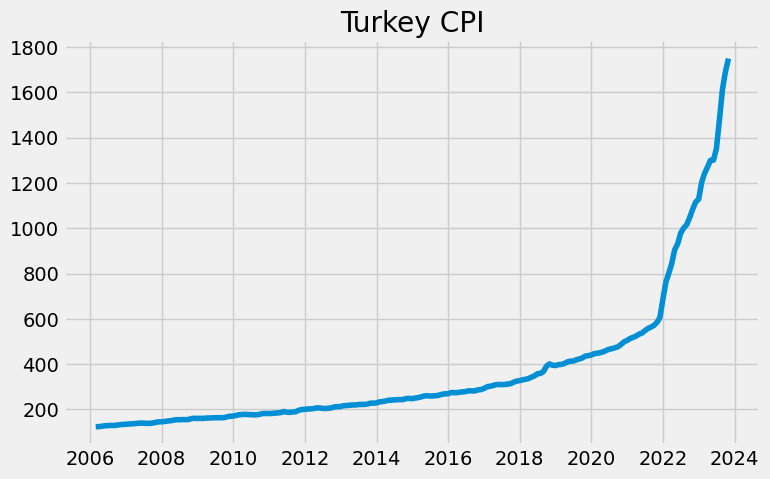

In [8]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)
plt.figure(figsize=(8,5))
plt.title("Turkey CPI")
plt.plot(df)
plt.show()


In [9]:
df6=pd.DataFrame()
df6["USD/TL"]=usd["TP_DK_USD_S_YTL"]

df6["USD/TL"]=df6["USD/TL"].astype(float)
df6

,USD/TL
Tarih,
2006-02-28,1.326535
2006-03-31,1.335139
2006-04-30,1.337345
2006-05-31,1.420659
2006-06-30,1.600536
...,...
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448


In [10]:
money=evds.get_data(["TP.PR.ARZ13"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del money["Tarih"]
money=pd.DataFrame(money)
money.columns=["Para Arzi"]
money=money/1e+08
money=money.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
money

,Para Arzi
2006-02-28,2.423895
2006-03-31,2.494857
2006-04-30,2.521919
2006-05-31,2.751947
2006-06-30,2.791388
...,...
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320


In [11]:
m3=evds.get_data(["TP.PR.ARZ22"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del m3["Tarih"]
m3.columns=["M3 Para Arzi"]
m3=m3/1e+08
m3=m3.set_index(money.index)
m3

,M3 Para Arzi
2006-02-28,2.663248
2006-03-31,2.731552
2006-04-30,2.767716
2006-05-31,3.025340
2006-06-30,3.038097
...,...
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329


In [12]:

issizlik=evds.get_data(["TP.TIG08"],startdate="28-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del issizlik["Tarih"]
issizlik.columns=["İşsizlik"]
issizlik=issizlik.dropna(axis=0)
issizlik=issizlik.set_index(pd.date_range(start="2014-01-30",end="2023-09-29",freq="1M"))
issizlik

,İşsizlik
2014-01-31,9.2
2014-02-28,9.5
2014-03-31,9.5
2014-04-30,9.7
2014-05-31,9.7
...,...
2023-04-30,10.0
2023-05-31,9.5
2023-06-30,9.6
2023-07-31,9.4


In [13]:
brent=evds.get_data(["TP.BRENTPETROL.EUBP"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=1)
brent

,Tarih,TP_BRENTPETROL_EUBP
0,01-02-2006,65.64
1,02-02-2006,63.49
2,03-02-2006,62.54
3,06-02-2006,63.32
4,07-02-2006,61.64
...,...,...
4624,24-10-2023,88.00
4625,25-10-2023,90.14
4626,26-10-2023,88.45
4627,27-10-2023,90.73


In [14]:
brent['Tarih'] = pd.to_datetime(brent['Tarih'], format='%d-%m-%Y')

# Tarihi indeks olarak ayarla
brent.set_index('Tarih', inplace=True)

# Aylık ortalama değerleri hesapla
brent = brent.resample('M').mean()

# Sonucu görüntüle

newrow=pd.DataFrame({"TP_BRENTPETROL_EUBP":83.88},index=pd.date_range(start="2023-11-30",periods=1,freq="1M"))

brent=pd.concat([brent,newrow],axis=0)
brent

,TP_BRENTPETROL_EUBP
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.775714


In [15]:
df14=pd.DataFrame()
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')

df14["Brent"]=brent["TP_BRENTPETROL_EUBP"]
df14["TIME"]=dates
df14['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df14['TIME'] =  pd.to_datetime(df14['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df14 = df14.set_index(['TIME'])

df14

,Brent
TIME,
2006-02-28,60.210000
2006-03-31,62.064783
2006-04-30,70.260000
2006-05-31,69.776957
2006-06-30,68.555909
...,...
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381


In [16]:
kredi=evds.get_data(["TP.KREDI.L001"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kredi

,Tarih,TP_KREDI_L001
0,2006-2,1.381847e+08
1,2006-3,1.481222e+08
2,2006-4,1.527510e+08
3,2006-5,1.664881e+08
4,2006-6,1.740395e+08
...,...,...
209,2023-7,9.846895e+09
210,2023-8,9.923806e+09
211,2023-9,1.025829e+10
212,2023-10,1.047935e+10


In [17]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
kredi=pd.DataFrame(kredi)
kredi.columns=["Tarih","Kredi"]
kredi["Kredi"]=kredi["Kredi"]/1e+08
kredi

,Tarih,Kredi
0,2006-2,1.381847
1,2006-3,1.481222
2,2006-4,1.527510
3,2006-5,1.664881
4,2006-6,1.740395
...,...,...
209,2023-7,98.468952
210,2023-8,99.238055
211,2023-9,102.582870
212,2023-10,104.793503


In [18]:
df3=pd.DataFrame()
df3["Kredi"]=kredi["Kredi"]
df3["TIME"]=pd.date_range(start="2006-02-28",periods=len(df3),freq="1M")
df3['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
df3['TIME'] =  pd.to_datetime(df3['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
df3 = df3.set_index(['TIME'])
df3=df3.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
df3

,Kredi
2006-02-28,1.381847
2006-03-31,1.481222
2006-04-30,1.527510
2006-05-31,1.664881
2006-06-30,1.740395
...,...
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503


In [19]:
pfaiz=evds.get_data(["TP.APIFON4"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
pfaiz.columns=["Tarih","Faiz"]
pfaiz.iloc[:11,1]=17.5
pfaiz.iloc[11:23,1]=21.5
pfaiz.iloc[23:35,1]=19.25
pfaiz.iloc[35:47,1]=10.25
pfaiz.iloc[47:59,1]=8
pfaiz["Faiz"]=pfaiz["Faiz"].astype(float)
#pfaiz.iloc[212,1]=35
pfaiz



,Tarih,Faiz
0,2006-2,17.5
1,2006-3,17.5
2,2006-4,17.5
3,2006-5,17.5
4,2006-6,17.5
...,...,...
209,2023-7,17.5
210,2023-8,23.5
211,2023-9,31.0
212,2023-10,33.0


In [20]:
dates=pd.date_range('2006-02-28','2023-12-29' , freq='1M')
pfaiz=pd.DataFrame(pfaiz)
pfaiz.columns=["Tarih","Politika Faizi"]
pfaiz["TIME"]=dates
pfaiz['TIME'].replace(regex=True,inplace=True, to_replace='M',value='')
pfaiz['TIME'] =  pd.to_datetime(pfaiz['TIME'], format='%Y%m', errors='ignore', infer_datetime_format=True)
pfaiz = pfaiz.set_index(['TIME'])
del pfaiz["Tarih"]
pfaiz

,Politika Faizi
TIME,
2006-02-28,17.5
2006-03-31,17.5
2006-04-30,17.5
2006-05-31,17.5
2006-06-30,17.5
...,...
2023-07-31,17.5
2023-08-31,23.5
2023-09-30,31.0


In [21]:
kfaiz=evds.get_data(["TP.KTFTUK"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
kfaiz.columns=["Tarih","Kredi Faizi"]
kfaiz=kfaiz.set_index(kfaiz["Tarih"])
del kfaiz["Tarih"]
kfaiz=kfaiz.astype(float)
kfaiz=kfaiz.set_index(pd.date_range('2006-02-28','2023-12-29' , freq='1M'))
kfaiz

,Kredi Faizi
2006-02-28,17.2975
2006-03-31,17.0080
2006-04-30,16.2075
2006-05-31,16.3000
2006-06-30,19.6700
...,...
2023-07-31,45.8250
2023-08-31,45.7650
2023-09-30,56.3500
2023-10-31,59.3925


In [22]:
perakende=pd.read_excel("./perakende satis hacim endeksi ve degisim oranlari (sabit fiyatlarla) (2015=100).xls")
perakende1=perakende.iloc[5:,2].dropna(axis=0).astype(float)
perakende1=pd.DataFrame(perakende1)
perakende1.columns=["Arındırılmamış"]


perakende1["Takvimden Arındırılmış"]=perakende.iloc[5:169,4].astype(float)
perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]=perakende.iloc[5:169,7].astype(float)
perakende1=perakende1.set_index(pd.date_range(start="2010-01-01",end="2023-09-01",freq="1M"))
perakende1

,Arındırılmamış,Takvimden Arındırılmış,Mevsimsellikten ve Takvimden Arındırılmış
2010-01-31,57.403841,57.747949,67.560585
2010-02-28,57.317027,57.179176,68.192727
2010-03-31,67.904361,67.034985,69.536955
2010-04-30,67.048510,66.458455,70.175625
2010-05-31,70.327428,70.614865,70.604236
...,...,...,...
2023-04-30,165.916139,169.886079,174.404111
2023-05-31,181.176925,179.726145,180.185729
2023-06-30,180.070938,186.141640,180.131292
2023-07-31,191.355951,193.831190,185.482059


In [23]:
motorin=pd.read_excel("./motorin.xlsx")
motorin.columns=["Tarih","Motorin"]
motorin=motorin.set_index(pd.date_range(start="2003-01-01",end="2023-11-01",freq="1M"))
del motorin["Tarih"]
motorin=motorin.astype(float)
motorin

,Motorin
2003-01-31,1.366645
2003-02-28,1.457199
2003-03-31,1.529555
2003-04-30,1.439813
2003-05-31,1.404363
...,...
2023-06-30,22.100000
2023-07-31,29.480000
2023-08-31,37.370000
2023-09-30,39.180000


In [44]:
sanayi=pd.read_excel("C:/Users/Bora/Downloads/sanayi uretim endeksi ve degisim oranlari (2015=100).xls")
sanayi=pd.DataFrame(sanayi.iloc[8:,5])
sanayi.columns=["Sanayi"]
sanayi=sanayi.set_index(pd.date_range(start="2005-02-08",periods=len(sanayi),freq="1M"))
sanayi=sanayi.dropna()
sanayi=sanayi.astype(float)
sanayi

,Sanayi
2005-02-28,57.747916
2005-03-31,57.058754
2005-04-30,57.685141
2005-05-31,58.226534
2005-06-30,58.022939
...,...
2023-05-31,146.666835
2023-06-30,148.351267
2023-07-31,147.798299
2023-08-31,146.674452


In [31]:
mfaiz=evds.get_data(["TP.TRY.MT02"],startdate="01-02-2006",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
mfaiz=mfaiz.set_index(pd.date_range(start="2006-02-01",end="2023-12-01",freq="1M"))
del mfaiz["Tarih"]
mfaiz.columns=["Mevduat Faizi"]
mfaiz

,Mevduat Faizi
2006-02-28,15.7600
2006-03-31,15.3300
2006-04-30,15.1750
2006-05-31,14.9250
2006-06-30,15.5840
...,...
2023-07-31,33.1250
2023-08-31,29.4125
2023-09-30,41.6560
2023-10-31,43.8925


In [32]:
from datetime import date
enf_belirsizlik=evds.get_data(["TP.BEK.S01.E.S"],startdate="30-06-2013",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
enf_belirsizlik=enf_belirsizlik.set_index(pd.date_range(start="2013-06-30",end="2023-11-29",freq="1M"))
del enf_belirsizlik["Tarih"]
enf_belirsizlik.columns=["Enflasyon Belirsizliği"]
enf_belirsizlik

,Enflasyon Belirsizliği
2013-06-30,0.62
2013-07-31,0.74
2013-08-31,0.74
2013-09-30,0.77
2013-10-31,0.65
...,...
2023-06-30,7.55
2023-07-31,7.70
2023-08-31,6.81
2023-09-30,7.30


In [33]:
borc=evds.get_data(["TP.KB.A09"],startdate="28-02-2010",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del borc["Tarih"]
borc=borc.set_index(pd.date_range(start="2010-02-28",end="2023-10-29",freq="1M"))
borc.columns=["Borç"]
borc

,Borç
2010-02-28,3.394344e+08
2010-03-31,3.406784e+08
2010-04-30,3.431629e+08
2010-05-31,3.405206e+08
2010-06-30,3.431419e+08
...,...
2023-05-31,2.348115e+09
2023-06-30,2.575631e+09
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09


In [34]:
redk=evds.get_data(["TP.RK.U01.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redk["Tarih"]
redk=redk.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redk.columns=["REDK"]
redk

,REDK
2011-03-31,105.42
2011-04-30,107.10
2011-05-31,103.79
2011-06-30,101.84
2011-07-31,98.49
...,...
2023-06-30,87.02
2023-07-31,81.68
2023-08-31,85.52
2023-09-30,89.55


In [35]:
redkt=evds.get_data(["TP.RK.T1.Y"],startdate="31-03-2011",enddate=date.today().strftime("%d-%m-%Y"),frequency=5)
del redkt["Tarih"]
redkt=redkt.set_index(pd.date_range(start="2011-03-30",end="2023-11-29",freq="1M"))
redkt.columns=["REDKT"]
redkt

,REDKT
2011-03-31,111.62
2011-04-30,114.17
2011-05-31,112.89
2011-06-30,108.98
2011-07-31,104.82
...,...
2023-06-30,51.56
2023-07-31,48.68
2023-08-31,52.39
2023-09-30,55.46


In [46]:
data=pd.DataFrame()
data["USDTL"]=df6["USD/TL"].rolling(3).mean()
data["ParaArzi"]=money["Para Arzi"].shift(1)
data["Motorin"]=motorin["Motorin"]
data["Perakende Satış"]=perakende1["Mevsimsellikten ve Takvimden Arındırılmış"]
data["Sanayi"]=sanayi["Sanayi"]
data["Borç"]=borc["Borç"].shift(1)
data["Kredi"]=df3["Kredi"].rolling(2).mean()
data["REDK"]=redk["REDK"]
data["REDKT"]=redkt["REDKT"]
data["M3"]=m3["M3 Para Arzi"].shift(1)
data["TÜFE"]=df["CPI"]
data=data.pct_change(periods=1)*100
data=data.dropna(axis=0)
data

,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.970482,-0.372743,9.689321,5.675617,-6.136520,-5.585725,15.439600,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.670450,-0.760392,2.618269,1.850455,4.701273,7.621200,5.968276,9.086793
2023-09-30,5.071342,4.764088,4.843457,0.000000,-0.125062,4.384930,2.080815,4.712348,5.859897,4.845313,4.753114


In [47]:
data.iloc[-2,3:7]=[0.34,0.35,3.750938,2.154973]
data.iloc[-2,9:]=[3.373522,3.43]
data.iloc[-3,3:4]=[-2.91]
data


,USDTL,ParaArzi,Motorin,Perakende Satış,Sanayi,Borç,Kredi,REDK,REDKT,M3,TÜFE
Tarih,,,,,,,,,,,
2011-04-30,-0.810542,1.738088,-1.218711,-0.176965,-0.162949,0.684613,2.978727,1.593625,2.284537,1.642254,0.866270
2011-05-31,-0.399628,0.113812,-1.660706,1.110822,1.016932,0.570506,3.568114,-3.090570,-1.121135,0.477281,2.420827
2011-06-30,0.415548,2.361933,2.055258,2.490629,1.895703,0.194110,3.122424,-1.878794,-3.463549,2.450559,-1.430743
2011-07-31,2.804715,2.187652,2.237631,1.258223,1.925345,0.019793,2.898935,-3.289474,-3.817214,2.189939,-0.409400
2011-08-31,3.747733,0.569285,1.664460,-0.296514,2.983648,0.318355,3.279260,-4.213626,-5.533295,0.444077,0.726069
...,...,...,...,...,...,...,...,...,...,...,...
2023-07-31,11.475241,15.146856,33.393665,2.970482,-0.372743,9.689321,5.675617,-6.136520,-5.585725,15.439600,9.488824
2023-08-31,10.505114,5.943431,26.763908,-4.670450,-0.760392,2.618269,1.850455,4.701273,7.621200,5.968276,9.086793
2023-09-30,5.071342,4.764088,4.843457,-2.910000,-0.125062,4.384930,2.080815,4.712348,5.859897,4.845313,4.753114


In [48]:
new_row=pd.DataFrame({"İşsizlik":[9.22,9.23]})
new_row=new_row.set_index(pd.date_range(start="2023-09-30",periods=2,freq="1M"))
issizlik=pd.concat([issizlik,new_row],axis=0)
issizlik

,İşsizlik
2014-01-31,9.20
2014-02-28,9.50
2014-03-31,9.50
2014-04-30,9.70
2014-05-31,9.70
...,...
2023-06-30,9.60
2023-07-31,9.40
2023-08-31,9.20
2023-09-30,9.22


In [49]:

data["Enflasyon Belirsizliği"]=enf_belirsizlik
data["Kredi Faizi"]=kfaiz["Kredi Faizi"]
data["Mevduat Faizi"]=mfaiz["Mevduat Faizi"]
data["Zam"]=0
data["Politika Faizi"]=pfaiz["Politika Faizi"]
data["İşsizlik"]=issizlik["İşsizlik"]
yearly_mean = data.groupby(data.index.year)['TÜFE'].mean()
data['Şok'] = (data.index.year.map(yearly_mean) < data['TÜFE']).astype(int)
data=data.dropna(axis=0)
data=data[['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi','Zam', 'Sanayi', 'Enflasyon Belirsizliği','ParaArzi','Borç','Kredi','Mevduat Faizi','REDK','REDKT','Şok','M3','İşsizlik','Politika Faizi',"TÜFE"]]
data.iloc[0,4]=11.01
data.iloc[12,4]=12.3
data.iloc[24,4]=29.32
data.iloc[36,4]=7.92
data.iloc[48,4]=14.17
data.iloc[60,4]=25.45
data.iloc[72,4]=15
data.iloc[84,4]=26.56
data.iloc[96,4]=50
data.iloc[102,4]=30
data.iloc[108,4]=54
data.iloc[114,4]=34
data

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi,TÜFE
Tarih,,,,,,,,,,,,,,,,,,
2014-01-31,3.732429,2.881984,3.944616,13.5140,11.01,3.604096,0.82,3.375162,-0.584687,3.267877,9.0220,-3.691204,-5.094658,1,3.413428,9.20,9.96,1.978080
2014-02-28,3.033477,1.685899,-4.487196,15.4575,0.00,-0.850238,0.73,1.804994,0.808574,1.451593,10.6275,2.179150,0.919060,0,2.079333,9.50,10.23,0.428192
2014-03-31,2.465778,-2.278097,-0.070420,15.8900,0.00,0.128936,0.80,0.451349,0.193691,0.341852,11.3125,0.471546,0.641623,1,0.229599,9.50,10.27,1.125608
2014-04-30,-1.344724,-6.214384,-0.769499,15.8625,0.00,-0.863760,0.73,0.796760,0.478162,0.129671,11.0200,4.682667,5.892031,1,0.730196,9.70,10.03,1.344970
2014-05-31,-1.859714,-0.561578,0.433585,15.4280,0.00,-1.367417,0.80,-0.362357,0.091080,0.468727,10.4940,1.283880,2.058652,0,-0.093468,9.70,9.53,0.395224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-30,7.066073,16.807611,-0.030212,38.5600,0.00,1.148476,7.55,-1.017069,2.406884,5.711697,39.5920,-7.925087,-11.057444,0,-1.142443,9.60,12.84,3.920498
2023-07-31,11.475241,33.393665,2.970482,45.8250,34.00,-0.372743,7.70,15.146856,9.689321,5.675617,33.1250,-6.136520,-5.585725,1,15.439600,9.40,17.50,9.488824
2023-08-31,10.505114,26.763908,-4.670450,45.7650,0.00,-0.760392,6.81,5.943431,2.618269,1.850455,29.4125,4.701273,7.621200,1,5.968276,9.20,23.50,9.086793


In [59]:
features=data.iloc[:,:-1].columns
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
best_mse=float("inf")
best_features=[]
for r in range(3, 18):
    for combo in combinations(features, r):
        selected_features = list(combo)
        X_train_subset = X_train[selected_features]
        X_test_subset = X_test[selected_features]
        
        # MLP Regressor modelini oluşturun ve eğitin
        krr = KernelRidge(alpha=1.0)
        krr.fit(X_train_subset, y_train)
        
        
        
        # Modeli kullanarak tahmin yapın
        y_pred = krr.predict(X_test_subset)
        
        # Ortalama kare hata (MSE) hesaplayın
        rmse1 = np.sqrt(mean_squared_error(y_test, y_pred))
        
        # En iyi MSE değerini ve özellik kombinasyonunu güncelleyin
        if rmse1 < best_mse:
            best_mse = rmse1
            best_features = selected_features

# En iyi özellik kombinasyonu ve MSE değeri
print("En iyi özellik kombinasyonu:")
print(best_features)
print("En iyi MSE değeri:", best_mse)

En iyi özellik kombinasyonu:
['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Sanayi', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
En iyi MSE değeri: 0.17699081653558033


In [127]:
import statsmodels.api as sm
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Zam', 'Sanayi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data[["TÜFE"]]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
model=LinearRegression()
model.fit(X_train,y_train)
rmse=[]
tahminler=pd.DataFrame()
tahminler["Aylık Enflasyon"]=y_test
tahminler["Linear Regression"]=model.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Linear Regression"])))


In [128]:
from sklearn import linear_model
from sklearn.metrics import  mean_squared_error
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'REDK', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)

tahminler["Bayesian Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Bayesian Regression"])))


In [129]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Kredi Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]

reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train,y_train)

tahminler["Lasso Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lasso Regression"])))

In [130]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'REDK', 'İşsizlik', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=1000, tol=1e-3))
reg.fit(X_train, y_train)

tahminler["SGD Regressor"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["SGD Regressor"])))

In [131]:

from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Sanayi', 'ParaArzi', 'REDK', 'M3']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [132]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.fit(X_train, y_train) 
        

        



tahminler["Gaussian Regression"]=gpr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Gaussian Regression"])))



In [133]:
from sklearn.datasets import load_diabetes
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.kernel_ridge import KernelRidge
warnings.filterwarnings("ignore")
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Sanayi', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
krr = KernelRidge(alpha=1.0)
krr.fit(X_train, y_train)
        

        



tahminler["Kernel Regression"]=krr.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Kernel Regression"])))



In [134]:
rmse_df=pd.DataFrame(rmse,index=[tahminler.columns[1:]])
rmse_df.columns=["RMSE"]
rmse_df=rmse_df.sort_values(by="RMSE")
rmse_df

,RMSE
Lars Regression,0.097729
Kernel Regression,0.176991
Linear Regression,0.195305
Gaussian Regression,0.199298
Bayesian Regression,0.298593
SGD Regressor,0.301221
Lasso Regression,0.660878


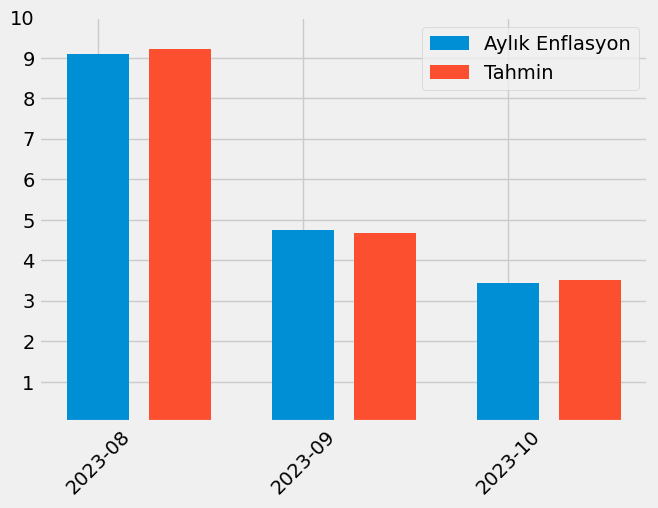

In [69]:
X_axis = np.arange(len(tahminler))
plt.figure(figsize=(7,5)) 
plt.bar(X_axis,tahminler["Aylık Enflasyon"],width=0.3,label="Aylık Enflasyon")
plt.bar(X_axis+0.4,tahminler["Lars Regression"],width=0.3,label="Tahmin")
plt.xticks(X_axis,tahminler.index.strftime("%Y-%m"),rotation=45)
plt.yticks(np.arange(1,11,1))
plt.legend()

In [70]:
from statsmodels.tsa.arima.model import ARIMA

model = SARIMAX(df6["USD/TL"].head(213), order=(0,2,1),seasonal_order=(0,0,0,12),trend='c')
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[208:,0]},index=pd.date_range(start="2023-06-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.670384
2023-12-31,29.498688
2024-01-31,30.331025
2024-02-29,31.167397
2024-03-31,32.007802


In [72]:
from statsmodels.tsa.ar_model import AutoReg
import statsmodels as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.model_selection import ParameterGrid
from statsmodels.tsa.api import VAR
from statsmodels.graphics.tsaplots import month_plot
import warnings


model = SARIMAX(df14["Brent"], order=(1, 1, 0),seasonal_order=(1,0,1,6))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
brenttahmin=pd.DataFrame(forecast_values)
brenttahmin.columns=["Brent"]
row=pd.DataFrame({"Brent":df14.iloc[209:214,0]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M"))
brenttahmin=pd.concat([row,brenttahmin],axis=0)
brenttahmin

,Brent
2023-07-31,80.108095
2023-08-31,86.147727
2023-09-30,93.722381
2023-10-31,90.775714
2023-11-30,83.880000
2023-12-31,82.229204
2024-01-31,79.411680
2024-02-29,78.265820
2024-03-31,76.626093
2024-04-30,76.755318


In [73]:
model = SARIMAX(perakende1["Mevsimsellikten ve Takvimden Arındırılmış"], order=(2,1,2),seasonal_order=(1,0,0,3))
model_fit = model.fit()
perakendetahmin = model_fit.forecast(steps=28)
perakendetahmin=pd.DataFrame(perakendetahmin)
perakendetahmin.columns=["Perakende"]
row=pd.DataFrame({"Perakende":perakende1.iloc[163,0]},index=pd.date_range(start="2023-08-30",end="2023-09-29",freq="1M"))
perakendetahmin=pd.concat([row,perakendetahmin],axis=0)
perakendetahmin

,Perakende
2023-08-31,184.748497
2023-09-30,179.379010
2023-10-31,179.980940
2023-11-30,179.228925
2023-12-31,176.863741
2024-01-31,178.070024
2024-02-29,180.527099
2024-03-31,180.388917
2024-04-30,177.787769
2024-05-31,177.103386


In [99]:
model = SARIMAX(money["Para Arzi"], order=(0,2,2))
model_fit = model.fit()


# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
paraarzitahmin=pd.DataFrame(forecast_values)
paraarzitahmin.columns=["Para Arzi"]
paraarzitahmin=pd.concat([pd.DataFrame({"Para Arzi":money.iloc[209:,0]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M")),paraarzitahmin],axis=0)
paraarzitahmin

,Para Arzi
2023-07-31,114.784753
2023-08-31,120.253200
2023-09-30,123.493114
2023-10-31,127.637320
2023-11-30,127.610812
2023-12-31,131.492162
2024-01-31,135.244743
2024-02-29,138.997325
2024-03-31,142.749906
2024-04-30,146.502488


In [95]:
model = SARIMAX(kfaiz["Kredi Faizi"], order=(1,1,0),seasonal_order=(0,0,0,12))
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kfaiztahmin=pd.DataFrame(forecast_values)
kfaiztahmin.columns=["Kredi Faizi"]
new_row=pd.DataFrame({"Kredi Faizi":kfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
kfaiztahmin=pd.concat([new_row,kfaiztahmin],axis=0)
kfaiztahmin



,Kredi Faizi
2023-08-31,45.765000
2023-09-30,56.350000
2023-10-31,59.392500
2023-11-30,58.700000
2023-12-31,58.373622
2024-01-31,58.219798
2024-02-29,58.147300
2024-03-31,58.113132
2024-04-30,58.097028
2024-05-31,58.089438


In [94]:
model = ARIMA(mfaiz, order=(3, 1, 1))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
mfaiztahmin=pd.DataFrame(forecast_values)
mfaiztahmin.columns=["Mevduat Faizi"]
new_row=pd.DataFrame({"Mevduat Faizi":mfaiz.iloc[210:,0]},index=pd.date_range(start="2023-08-30",end="2023-12-29",freq="1M"))
mfaiztahmin=pd.concat([new_row,mfaiztahmin],axis=0)
mfaiztahmin

,Mevduat Faizi
2023-08-31,29.412500
2023-09-30,41.656000
2023-10-31,43.892500
2023-11-30,44.500000
2023-12-31,50.668684
2024-01-31,50.283845
2024-02-29,49.346119
2024-03-31,51.818756
2024-04-30,51.435179
2024-05-31,50.671628


In [77]:
usdtahmin["brent"]=brenttahmin
usdtahmin=usdtahmin.dropna(axis=0)
degisim=pd.DataFrame((((usdtahmin["USDTL"]*usdtahmin["brent"]).pct_change(periods=1)+1).values)[1:],index=pd.date_range(start="2023-08-30",end="2026-01-30",freq="1M"))
degisim.columns=["Değişim"]
degisim=degisim.iloc[2:]
degisim

,Değişim
2023-10-31,0.999302
2023-11-30,0.951388
2023-12-31,1.008642
2024-01-31,0.992985
2024-02-29,1.012748
2024-03-31,1.005449
2024-04-30,1.028113
2024-05-31,1.046284
2024-06-30,1.039637
2024-07-31,1.007567


In [78]:
motorintahmin=pd.DataFrame()
motorintahmin["Değişim"]=degisim
motorintahmin["Motorin"]=38.9
for i in range(1,27):
    motorintahmin.iloc[i,1]=motorintahmin.iloc[i,0]*motorintahmin.iloc[i-1,1]

del motorintahmin["Değişim"]
new_row=pd.DataFrame({"Motorin":motorin.iloc[247,0]},index=pd.date_range(start="2023-11-30",end="2023-09-29",freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-10-31,38.900000
2023-11-30,37.008993
2023-12-31,37.328808
2024-01-31,37.066947
2024-02-29,37.539459
2024-03-31,37.743996
2024-04-30,38.805101
2024-05-31,40.601169
2024-06-30,42.210473
2024-07-31,42.529881


In [79]:

zamtahmin=pd.DataFrame()
zamtahmin["Zam"]=[0,00,0,0,0,35,0,0,0,0,0,0,0,0,0,0,0,30,0,0,0,0,0,0,0,0,0,0,0]
zamtahmin.columns=["Zam"]
zamtahmin=zamtahmin.set_index(pd.date_range(start="2023-08-30",end="2026-01-27",freq="1M"))
zamtahmin

,Zam
2023-08-31,0
2023-09-30,0
2023-10-31,0
2023-11-30,0
2023-12-31,0
2024-01-31,35
2024-02-29,0
2024-03-31,0
2024-04-30,0
2024-05-31,0


In [98]:
model = ARIMA(df3["Kredi"], order=(5, 2, 0))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26 # 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
kreditahmin=pd.DataFrame(forecast_values)
kreditahmin.columns=["Kredi"]
new_row=pd.DataFrame({"Kredi":df3["Kredi"].iloc[209:]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M"))
kreditahmin=pd.concat([new_row,kreditahmin],axis=0)
kreditahmin

,Kredi
2023-07-31,98.468952
2023-08-31,99.238055
2023-09-30,102.582870
2023-10-31,104.793503
2023-11-30,105.562238
2023-12-31,109.896342
2024-01-31,113.182658
2024-02-29,114.632479
2024-03-31,118.035975
2024-04-30,120.963485


In [81]:
model = ARIMA(borc["Borç"], order=(0, 2, 1), seasonal_order=(0, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
borctahmin=pd.DataFrame(forecast_values)
borctahmin.columns=["Borç"]
new_row=pd.DataFrame({"Borç":[2643068440,2758965144,2859751220]},index=pd.date_range(start="2023-07-30",end="2023-10-29",freq="1M"))
borctahmin=pd.concat([new_row,borctahmin],axis=0)
borctahmin

,Borç
2023-07-31,2.643068e+09
2023-08-31,2.758965e+09
2023-09-30,2.859751e+09
2023-10-31,2.967250e+09
2023-11-30,3.074749e+09
2023-12-31,3.182249e+09
2024-01-31,3.289748e+09
2024-02-29,3.397247e+09
2024-03-31,3.504746e+09
2024-04-30,3.612245e+09


In [82]:
model = SARIMAX(redk["REDK"], order=(1, 1, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redktahmin=pd.DataFrame(forecast_values)
redktahmin.columns=["REDK"]
new_row=pd.DataFrame({"REDK":[85.52,89.55,89.03]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redktahmin=pd.concat([new_row,redktahmin],axis=0)
redktahmin

,REDK
2023-08-31,85.520000
2023-09-30,89.550000
2023-10-31,89.030000
2023-11-30,88.272991
2023-12-31,88.002239
2024-01-31,87.777102
2024-02-29,87.585270
2024-03-31,87.417756
2024-04-30,87.267999
2024-05-31,87.131207


In [83]:
model = SARIMAX(redkt["REDKT"], order=(1, 1, 2), seasonal_order=(1, 0, 0, 10),trend='c')

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 27# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
redkttahmin=pd.DataFrame(forecast_values)
redkttahmin.columns=["REDKT"]
new_row=pd.DataFrame({"REDKT":[52.39,55.46,55.90]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
redkttahmin=pd.concat([new_row,redkttahmin],axis=0)
redkttahmin

,REDKT
2023-08-31,52.390000
2023-09-30,55.460000
2023-10-31,55.900000
2023-11-30,54.460918
2023-12-31,53.079366
2024-01-31,52.018375
2024-02-29,51.359168
2024-03-31,50.888966
2024-04-30,51.523293
2024-05-31,51.517532


In [101]:
model = SARIMAX(m3["M3 Para Arzi"], order=(1, 2, 2),trend='c')

# Modeli eğitin
model_fit = model.fit()

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
m3tahmin=pd.DataFrame(forecast_values)
m3tahmin.columns=["M3 Para Arzi"]
new_row=pd.DataFrame({"M3 Para Arzi":m3["M3 Para Arzi"].iloc[209:]},index=pd.date_range(start="2023-07-30",end="2023-12-29",freq="1M"))
m3tahmin=pd.concat([new_row,m3tahmin],axis=0)
m3tahmin

,M3 Para Arzi
2023-07-31,117.729650
2023-08-31,123.434020
2023-09-30,126.660411
2023-10-31,130.933329
2023-11-30,131.064144
2023-12-31,136.121309
2024-01-31,139.276848
2024-02-29,144.244310
2024-03-31,147.558189
2024-04-30,152.452515


In [85]:
model = SARIMAX(issizlik["İşsizlik"], order=(2, 1, 2), seasonal_order=(1, 0, 0, 12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
issizliktahmin=pd.DataFrame(forecast_values)
issizliktahmin.columns=["İşsizlik"]
new_row=pd.DataFrame({"İşsizlik":[9.23]},index=pd.date_range(start="2023-10-30",end="2023-11-29",freq="1M"))
issizliktahmin=pd.concat([new_row,issizliktahmin],axis=0)
issizliktahmin

,İşsizlik
2023-10-31,9.230000
2023-11-30,9.149737
2023-12-31,9.174256
2024-01-31,9.339446
2024-02-29,9.172552
2024-03-31,9.193320
2024-04-30,9.271810
2024-05-31,9.320286
2024-06-30,9.264167
2024-07-31,9.379936


In [86]:
model = SARIMAX(enf_belirsizlik["Enflasyon Belirsizliği"], order=(0, 1, 0),seasonal_order=(0,0,1,12))

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 26# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
enfbelirsizliktahmin=pd.DataFrame(forecast_values)
enfbelirsizliktahmin.columns=["Enflasyon Belirsizliği"]
new_row=pd.DataFrame({"Enflasyon Belirsizliği":[6.81,7.3,5.57]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
enfbelirsizliktahmin=pd.concat([new_row,enfbelirsizliktahmin],axis=0)
enfbelirsizliktahmin

,Enflasyon Belirsizliği
2023-08-31,6.810000
2023-09-30,7.300000
2023-10-31,5.570000
2023-11-30,5.736679
2023-12-31,5.801851
2024-01-31,5.993937
2024-02-29,5.550952
2024-03-31,5.503268
2024-04-30,5.534476
2024-05-31,5.388792


In [88]:
model = SARIMAX(sanayi["Sanayi"], order=(2, 1, 1), seasonal_order=(1, 0, 2, 12),trend='c')

# Modeli eğitin
model_fit = model.fit(disp=0)

# Gelecekteki değerleri tahmin edin
n_forecast = 28# 12 aylık bir tahmin yapalım (örnek olarak)
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_values = forecast.predicted_mean
sanayitahmin=pd.DataFrame(forecast_values)
sanayitahmin.columns=["Sanayi"]
new_row=pd.DataFrame({"Sanayi":[146.67,146.49]},index=pd.date_range(start="2023-08-30",end="2023-10-29",freq="1M"))
sanayitahmin=pd.concat([new_row,sanayitahmin],axis=0)
sanayitahmin

,Sanayi
2023-08-31,146.670000
2023-09-30,146.490000
2023-10-31,147.015032
2023-11-30,146.415436
2023-12-31,146.370779
2024-01-31,147.584579
2024-02-29,145.578765
2024-03-31,147.926838
2024-04-30,150.872413
2024-05-31,150.143267


In [89]:

model = SARIMAX(df6["USD/TL"].iloc[:-1], order=(0,2,1),seasonal_order=(0,0,0,12))
model_fit = model.fit()
usdtahmin = model_fit.forecast(steps=26)
usdtahmin=pd.DataFrame(usdtahmin)
usdtahmin.columns=["USDTL"]
row=pd.DataFrame({"USDTL":df6.iloc[207:,0]},index=pd.date_range(start="2023-05-30",end="2023-11-29",freq="1M"))
usdtahmin=pd.concat([row,usdtahmin],axis=0)
usdtahmin

,USDTL
2023-05-31,19.719514
2023-06-30,23.106042
2023-07-31,26.470338
2023-08-31,26.999127
2023-09-30,26.989448
2023-10-31,27.846114
2023-11-30,28.674638
2023-12-31,29.503163
2024-01-31,30.331688
2024-02-29,31.160213


In [90]:
new_row=pd.DataFrame({"Motorin":39.18},index=pd.date_range(start="2023-09-30",periods=1,freq="1M"))
new_row=new_row.set_index(pd.date_range(start="2023-09-30",periods=1,freq="1M"))
motorintahmin=pd.concat([new_row,motorintahmin],axis=0)
motorintahmin

,Motorin
2023-09-30,39.180000
2023-10-31,38.900000
2023-11-30,37.008993
2023-12-31,37.328808
2024-01-31,37.066947
2024-02-29,37.539459
2024-03-31,37.743996
2024-04-30,38.805101
2024-05-31,40.601169
2024-06-30,42.210473


In [121]:
model = SARIMAX(pfaiz["Politika Faizi"].iloc[:-1], order=(1,1,1),seasonal_order=(0,0,0,12))
model_fit = model.fit()
faiztahmin = model_fit.forecast(steps=26)
faiztahmin=pd.DataFrame(faiztahmin)
faiztahmin.columns=["Politika Faizi"]
row=pd.DataFrame({"Politika Faizi":pfaiz.iloc[210:213,0]},index=pd.date_range(start="2023-08-30",end="2023-11-29",freq="1M"))
faiztahmin=pd.concat([row,faiztahmin],axis=0)
faiztahmin

,Politika Faizi
2023-08-31,23.500000
2023-09-30,31.000000
2023-10-31,33.000000
2023-11-30,35.383612
2023-12-31,37.256356
2024-01-31,38.727725
2024-02-29,39.883743
2024-03-31,40.791998
2024-04-30,41.505592
2024-05-31,42.066244


In [122]:
import statsmodels.api as sm
tahmindf=pd.DataFrame()
tahmindf=pd.concat([usdtahmin["USDTL"].rolling(3).mean(),paraarzitahmin["Para Arzi"].shift(1),motorintahmin["Motorin"],enfbelirsizliktahmin,perakendetahmin,sanayitahmin,kreditahmin.rolling(2).mean(),redktahmin,redkttahmin,m3tahmin.shift(1),borctahmin.shift(1)],axis=1)
tahmindf=tahmindf.pct_change(periods=1)*100
#tahmindf=tahmindf.dropna(axis=0)
tahmindf["Enflasyon Belirsizliği"]=enfbelirsizliktahmin
tahmindf["Zam"]=zamtahmin["Zam"]
tahmindf["Kredi Faizi"]=kfaiztahmin["Kredi Faizi"]
tahmindf["Mevduat Faizi"]=mfaiztahmin["Mevduat Faizi"]
tahmindf["İşsizlik"]=issizliktahmin
tahmindf["Politika Faizi"]=faiztahmin



tahmindf["Şok"]=0

tahmindf=tahmindf[['USDTL', 'Motorin', 'Perakende', 'Kredi Faizi', 'Zam', 'Sanayi',
       'Enflasyon Belirsizliği', 'Para Arzi', 'Borç', 'Kredi', 'Mevduat Faizi','REDK','REDKT','Şok','M3 Para Arzi','İşsizlik','Politika Faizi']]

tahmindf.columns=data.columns[:17]
tahmindf=tahmindf.dropna(axis=0)
tahmindf.iloc[-27:-12]

,USDTL,Motorin,Perakende Satış,Kredi Faizi,Zam,Sanayi,Enflasyon Belirsizliği,ParaArzi,Borç,Kredi,Mevduat Faizi,REDK,REDKT,Şok,M3,İşsizlik,Politika Faizi
2023-10-31,1.709911,-0.714650,0.335563,59.392500,0.0,0.358408,5.570000,2.694244,3.653039,2.752662,43.892500,-0.580681,0.793365,0,2.613859,9.230000,33.000000
2023-11-30,2.047434,-4.861202,-0.417831,58.700000,0.0,-0.407846,5.736679,3.355820,3.759038,1.436696,44.500000,-0.850286,-2.574387,0,3.373522,9.149737,35.383612
2023-12-31,3.010070,0.864155,-1.319644,58.373622,0.0,-0.030501,5.801851,-0.020769,3.622854,2.425814,50.668684,-0.306720,-2.536777,0,0.099910,9.174256,37.256356
2024-01-31,2.889399,-0.701499,0.682040,58.219798,35.0,0.829264,5.993937,3.041553,3.496192,3.536837,50.283845,-0.255832,-1.998876,0,3.858542,9.339446,38.727725
2024-02-29,2.808257,1.274754,1.379837,58.147300,0.0,-1.359095,5.550952,2.853844,3.378087,2.123076,49.346119,-0.218545,-1.267258,0,2.318181,9.172552,39.883743
2024-03-31,2.731548,0.544858,-0.076544,58.113132,0.0,1.612923,5.503268,2.774660,3.267702,2.130375,51.818756,-0.191258,-0.915518,0,3.566610,9.193320,40.791998
2024-04-30,2.658919,2.811321,-1.441967,58.097028,0.0,1.991238,5.534476,2.699751,3.164302,2.721042,51.435179,-0.171312,1.246494,0,2.297407,9.271810,41.505592
2024-05-31,2.590051,4.628435,-0.384944,58.089438,0.0,-0.483287,5.388792,2.628780,3.067245,1.784798,50.671628,-0.156749,-0.011181,0,3.316879,9.320286,42.066244
2024-06-30,2.524661,3.963687,1.274045,58.085861,0.0,-0.550260,5.336616,2.561446,2.975965,1.861086,51.775763,-0.146130,-2.431088,0,2.267433,9.264167,42.506735
2024-07-31,2.462492,0.756705,0.794594,58.084175,0.0,1.082896,5.384569,2.497474,2.889960,2.581852,51.596291,-0.138400,-2.201248,0,3.101560,9.379936,42.852818


In [123]:
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'REDK', 'İşsizlik', 'Politika Faizi']
X = data[features]
y=data["TÜFE"]
reg = make_pipeline(StandardScaler(),
                    SGDRegressor(max_iter=100000, tol=1e-6))
reg.fit(X, y)

tüfetahmin1 = []
result = 1691.04
sgdtahmin=reg.predict(tahmindf[features])
for i in range(len(sgdtahmin)):
    result *= (1 + sgdtahmin[i] / 100)
    tüfetahmin1.append(result)

tüfetahmin1 = np.array(tüfetahmin1).reshape(-1, 1)
tüfetahmin1 = pd.DataFrame(tüfetahmin1)
tüfetahmin1.columns = ["SGD Regressor"]
tüfetahmin1 = tüfetahmin1.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin1

,SGD Regressor
2023-10-31,1746.085106
2023-11-30,1790.826874
2023-12-31,1851.345719
2024-01-31,1906.860407
2024-02-29,1967.380141
2024-03-31,2024.327161
2024-04-30,2086.828708
2024-05-31,2156.188342
2024-06-30,2224.852163
2024-07-31,2284.884550


In [124]:
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Zam', 'Sanayi', 'REDK', 'REDKT', 'İşsizlik', 'Politika Faizi']



X = data[features]
model=LinearRegression()
model.fit(X, y)

tüfetahmin2 = []
result = 1691.04
lineartahmin = model.predict(np.array(tahmindf[features]))
lineartahmin=lineartahmin.ravel()
for i in range(len(lineartahmin)):
    result *= (1 + lineartahmin[i] / 100)
    tüfetahmin2.append(result)

tüfetahmin2 = np.array(tüfetahmin2).reshape(-1, 1)
tüfetahmin2 = pd.DataFrame(tüfetahmin2)
tüfetahmin2.columns = ["Linear Regression"]
tüfetahmin2 = tüfetahmin2.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin2


,Linear Regression
2023-10-31,1747.321533
2023-11-30,1787.239443
2023-12-31,1840.597078
2024-01-31,1917.956392
2024-02-29,1975.091759
2024-03-31,2030.061037
2024-04-30,2096.537556
2024-05-31,2165.572431
2024-06-30,2226.346104
2024-07-31,2279.931104


In [125]:
features=['USDTL', 'Motorin', 'Kredi Faizi']

X = data[features]
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X,y)


tüfetahmin5 = []
result = 1691.04
lassotahmin=reg.predict(tahmindf[features])
for i in range(len(lassotahmin)):
    result *= (1 + lassotahmin[i] / 100)
    tüfetahmin5.append(result)

tüfetahmin5 = np.array(tüfetahmin5).reshape(-1, 1)
tüfetahmin5 = pd.DataFrame(tüfetahmin5)
tüfetahmin5.columns = ["Lasso Regression"]
tüfetahmin5 = tüfetahmin5.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin5

,Lasso Regression
2023-10-31,1757.635033
2023-11-30,1818.962368
2023-12-31,1898.957358
2024-01-31,1978.147115
2024-02-29,2064.734646
2024-03-31,2152.863058
2024-04-30,2250.081532
2024-05-31,2356.100160
2024-06-30,2464.849641
2024-07-31,2568.868496


In [ ]:
warnings.filterwarnings("ignore")
features=['USDTL', 'Motorin', 'Perakende Satış', 'Sanayi', 'ParaArzi', 'REDK', 'M3']
X = data[features]
X_train=X.iloc[:-3,:]
X_test=X.iloc[-3:,:]
y_train=y.iloc[:-3,:]
y_test=y.iloc[-3:,:]
reg = linear_model.Lars(random_state=0)
reg.fit(X_train,y_train)

tahminler["Lars Regression"]=reg.predict(X_test)
rmse.append(np.sqrt(mean_squared_error(tahminler["Aylık Enflasyon"],tahminler["Lars Regression"])))

In [182]:
tahmindf.iloc[0,:]=data.iloc[-1,:-1]


In [184]:
features=['USDTL', 'Motorin', 'Perakende Satış', 'Sanayi', 'ParaArzi', 'REDK', 'M3']

X = data[features]
y=data["TÜFE"]
reg = linear_model.Lars(random_state=0)
reg.fit(X,y)



tüfetahmin6 = []
result = 1691.04
larstahmin=reg.predict(tahmindf[features])
for i in range(len(larstahmin)):
    result *= (1 + larstahmin[i] / 100)
    tüfetahmin6.append(result)

tüfetahmin6 = np.array(tüfetahmin6).reshape(-1, 1)
tüfetahmin6 = pd.DataFrame(tüfetahmin6)
tüfetahmin6.columns = ["Lars Regression"]
tüfetahmin6 = tüfetahmin6.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin6


,Lars Regression
2023-10-31,1729.261243
2023-11-30,1746.966768
2023-12-31,1770.894726
2024-01-31,1820.960605
2024-02-29,1842.995080
2024-03-31,1895.223161
2024-04-30,1921.840116
2024-05-31,1984.485888
2024-06-30,2019.039516
2024-07-31,2069.367212


In [185]:
features=['Motorin', 'Perakende Satış', 'Kredi Faizi', 'Sanayi', 'Kredi', 'Mevduat Faizi', 'REDK', 'REDKT', 'Politika Faizi']

X = data[features]
y=data["TÜFE"]
krr = KernelRidge()
krr.fit(X, y)

tüfetahmin7 = []
result = 1691.04
krrtahmin=krr.predict(tahmindf[features])
for i in range(len(krrtahmin)):
    result *= (1 + krrtahmin[i] / 100)
    tüfetahmin7.append(result)

tüfetahmin7 = np.array(tüfetahmin7).reshape(-1, 1)
tüfetahmin7 = pd.DataFrame(tüfetahmin7)
tüfetahmin7.columns = ["Kernel Regression"]
tüfetahmin7 = tüfetahmin7.set_index(pd.date_range(start="2023-10-30", end="2026-01-27", freq="1M"))
tüfetahmin7

,Kernel Regression
2023-10-31,1746.943970
2023-11-30,1768.285190
2023-12-31,1806.723126
2024-01-31,1851.343180
2024-02-29,1893.323959
2024-03-31,1933.091656
2024-04-30,2000.004174
2024-05-31,2058.274206
2024-06-30,2098.835772
2024-07-31,2138.564286


In [239]:

features=['USDTL', 'Motorin', 'Perakende Satış', 'Kredi Faizi', 'Zam', 'Sanayi', 'REDK', 'REDKT', 'Politika Faizi']

X = data[features]
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel)
y=data["TÜFE"]
gpr.fit(X, y) 


tüfe = 1691.04  # İlk değeri 1691 ile başlatıyoruz
tüfetahmin8 = []
gaustahmin=gpr.predict(tahmindf[features])
gaustahmin=1+(gaustahmin/100)
for elem in gaustahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin8.append(tüfe)
tüfetahmin8=pd.DataFrame(tüfetahmin8)
tüfetahmin8=tüfetahmin8.set_index(pd.date_range(start="2023-10-30",end="2026-01-27",freq="1M"))
tüfetahmin8.columns=["Gaussian Regression"]

tüfetahmin8
        

,Gaussian Regression
2023-10-31,1745.440610
2023-11-30,1783.973025
2023-12-31,1836.690545
2024-01-31,1913.394103
2024-02-29,1968.750827
2024-03-31,2023.288632
2024-04-30,2089.916230
2024-05-31,2158.210027
2024-06-30,2217.798373
2024-07-31,2270.603236


In [187]:
features=['USDTL', 'Motorin', 'Kredi Faizi', 'Sanayi', 'REDK', 'İşsizlik', 'Politika Faizi']
X = data[features]
reg = linear_model.BayesianRidge()
reg.fit(X, y)


tüfe = 1691.04 # İlk değeri 1691 ile başlatıyoruz
tüfetahmin9 = []
bayestahmin=reg.predict(tahmindf[features])
bayestahmin=1+(bayestahmin/100)
for elem in bayestahmin:
    tüfe *= elem  # Her elemanı sonuca çarp
    tüfetahmin9.append(tüfe)
tüfetahmin9=pd.DataFrame(tüfetahmin9)
tüfetahmin9=tüfetahmin9.set_index(pd.date_range(start="2023-10-30",end="2026-01-27",freq="1M"))
tüfetahmin9.columns=["Bayessian Regression"]

tüfetahmin9

,Bayessian Regression
2023-10-31,1748.537549
2023-11-30,1795.778335
2023-12-31,1858.861013
2024-01-31,1917.081583
2024-02-29,1980.810984
2024-03-31,2041.163608
2024-04-30,2107.485635
2024-05-31,2181.131617
2024-06-30,2254.375630
2024-07-31,2318.896858


In [236]:
tüfetahmin=pd.DataFrame()
tüfetahmin["SGD Regressor"]=tüfetahmin1["SGD Regressor"]
tüfetahmin["Linear Regression"]=tüfetahmin2["Linear Regression"]
tüfetahmin["Lasso Regression"]=tüfetahmin5["Lasso Regression"]
tüfetahmin["Lars Regression"]=tüfetahmin6["Lars Regression"]
tüfetahmin["Kernel Regression"]=tüfetahmin7["Kernel Regression"]
tüfetahmin["Gaussian Regression"]=tüfetahmin8["Gaussian Regression"]
tüfetahmin["Bayessian Regression"]=tüfetahmin9["Bayessian Regression"]
tüfetahmin["Ortalama"]=tüfetahmin.mean(axis=1)
#tüfetahmin.iloc[1,:]=tüfetahmin.iloc[1,:]+9.7
tüfetahmin

,SGD Regressor,Linear Regression,Lasso Regression,Lars Regression,Kernel Regression,Gaussian Regression,Bayessian Regression,Ortalama
2023-10-31,1746.085106,1747.321533,1757.635033,1729.261243,1746.943970,1745.440610,1748.537549,1745.889292
2023-11-30,1790.826874,1787.239443,1818.962368,1746.966768,1768.285190,1783.973025,1795.778335,1784.576000
2023-12-31,1851.345719,1840.597078,1898.957358,1770.894726,1806.723126,1836.690545,1858.861013,1837.724223
2024-01-31,1906.860407,1917.956392,1978.147115,1820.960605,1851.343180,1913.394103,1917.081583,1900.820483
2024-02-29,1967.380141,1975.091759,2064.734646,1842.995080,1893.323959,1968.750827,1980.810984,1956.155342
2024-03-31,2024.327161,2030.061037,2152.863058,1895.223161,1933.091656,2023.288632,2041.163608,2014.288330
2024-04-30,2086.828708,2096.537556,2250.081532,1921.840116,2000.004174,2089.916230,2107.485635,2078.956279
2024-05-31,2156.188342,2165.572431,2356.100160,1984.485888,2058.274206,2158.210027,2181.131617,2151.423239
2024-06-30,2224.852163,2226.346104,2464.849641,2019.039516,2098.835772,2217.798373,2254.375630,2215.156743
2024-07-31,2284.884550,2279.931104,2568.868496,2069.367212,2138.564286,2270.603236,2318.896858,2275.873677


In [227]:
dates=pd.date_range('2006-02-01','2023-11-01' , freq='1M')
df=pd.DataFrame()

df["CPI"]=inflation["TÜFE"]
df=df.set_index(dates)





dfas1=pd.DataFrame()
dfas1=pd.concat([df["CPI"],tüfetahmin.iloc[1:,0]],axis=0)
dfas1=pd.DataFrame(dfas1)
dfas1.columns=[tüfetahmin.columns[0]]

dfas2=pd.DataFrame()
dfas2=pd.concat([df["CPI"],tüfetahmin.iloc[1:,1]],axis=0)
dfas2=pd.DataFrame(dfas2)
dfas2.columns=[tüfetahmin.columns[1]]



dfas4=pd.DataFrame()
dfas4=pd.concat([df["CPI"],tüfetahmin.iloc[1:,2]],axis=0)
dfas4=pd.DataFrame(dfas4)
dfas4.columns=[tüfetahmin.columns[2]]

dfas5=pd.DataFrame()
dfas5=pd.concat([df["CPI"],tüfetahmin.iloc[1:,3]],axis=0)
dfas5=pd.DataFrame(dfas5)
dfas5.columns=[tüfetahmin.columns[3]]

'''dfas6=pd.DataFrame()
dfas6=pd.concat([df["CPI"],tüfetahmin.iloc[1:,4]],axis=0)
dfas6=pd.DataFrame(dfas6)
dfas6.columns=[tüfetahmin.columns[4]]

dfas7=pd.DataFrame()
dfas7=pd.concat([df["CPI"],tüfetahmin.iloc[1:,5]],axis=0)
dfas7=pd.DataFrame(dfas7)
dfas7.columns=[tüfetahmin.columns[5]]

dfas8=pd.DataFrame()
dfas8=pd.concat([df["CPI"],tüfetahmin.iloc[1:,6]],axis=0)
dfas8=pd.DataFrame(dfas8)
dfas8.columns=[tüfetahmin.columns[6]]

dfas9=pd.DataFrame()
dfas9=pd.concat([df["CPI"],tüfetahmin.iloc[1:,7]],axis=0)
dfas9=pd.DataFrame(dfas9)
dfas9.columns=[tüfetahmin.columns[7]]

dfas10=pd.DataFrame()
dfas10=pd.concat([df["CPI"],tüfetahmin.iloc[1:,8]],axis=0)
dfas10=pd.DataFrame(dfas10)
dfas10.columns=[tüfetahmin.columns[8]]'''





dfas=pd.DataFrame()
dfas=pd.concat([dfas1,dfas2,dfas4,dfas5],axis=1)
dfas=dfas.pct_change(periods=12)*100
dfas=dfas.dropna(axis=0)
dfas

df["Enflasyon"]=df["CPI"].pct_change(periods=12)*100
df=df.dropna(axis=0)








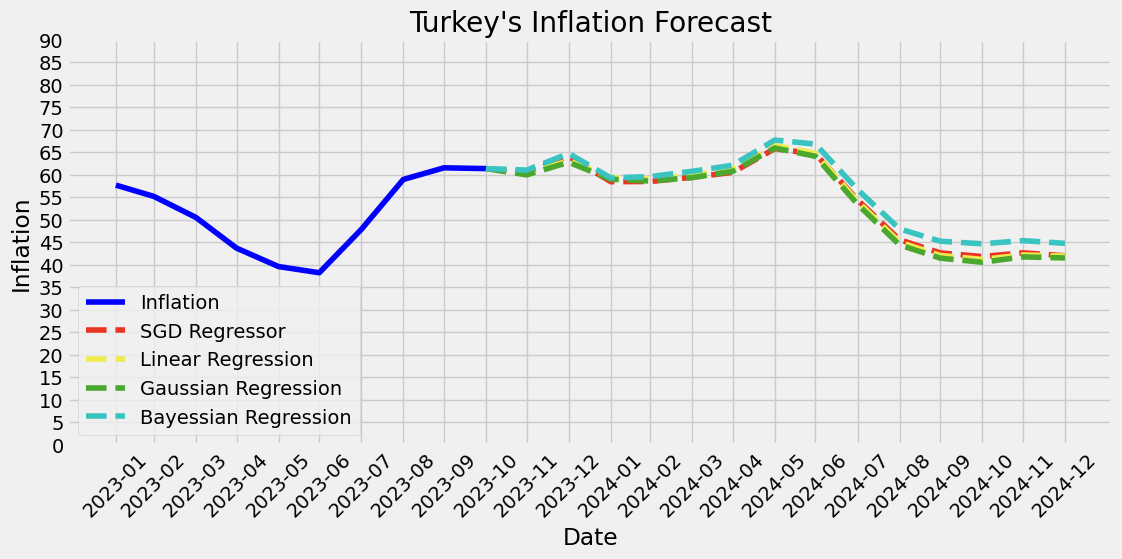

In [228]:








# Grafik çizdirelim
plt.figure(figsize=(12, 5))
plt.plot(df.iloc[191:201,1], label='Inflation', color='blue')
plt.plot(dfas.iloc[200:215,0],'--',label=dfas.columns[0], color='#EB3324')
plt.plot(dfas.iloc[200:215,1],'--',label=dfas.columns[1], color='#EDEB4F')
plt.plot(dfas.iloc[200:215,2],'--',label=dfas.columns[2], color='#4AA82E')
plt.plot(dfas.iloc[200:215,3],'--',label=dfas.columns[3], color='#39C4C2')
#plt.plot(dfas.iloc[200:215,4],'--',label=dfas.columns[4],color='#92BCC4')
#plt.plot(dfas.iloc[200:215,5],'--',label=dfas.columns[5],color='#AD4AC4')
#plt.plot(dfas.iloc[200:215,6],'--',label=dfas.columns[6],color='#DB8622')
#plt.plot(dfas.iloc[199:,7],'--',label=dfas.columns[7])
#plt.plot(dfas.iloc[199:,8],'--',label=dfas.columns[8])
plt.xlabel('Date')
plt.ylabel('Inflation')
plt.xticks(dfas.iloc[191:215].index, dfas.iloc[191:215].index.strftime('%Y-%m'), rotation=45)
y_max = 100
y_min = 10
y_interval = 0.5
y_ticks = [0]
while y_ticks[-1] < 90:
    y_ticks.append(y_ticks[-1] + 5)









# Y ekseni etiketlerini ayarlama
plt.yticks(y_ticks)
plt.title("Turkey's Inflation Forecast")
plt.legend(loc=3)
plt.grid(True)
plt.show()


In [229]:
ekim_tahmin=((tüfetahmin.iloc[0,:-1]/1691)-1)*100
np.abs(ekim_tahmin-3.43).sort_values()

Bayessian Regression    0.027425
Linear Regression       0.099336
SGD Regressor           0.172454
Gaussian Regression     0.210567
Name: 2023-10-31 00:00:00, dtype: float64

In [230]:
aylıktahmin=tüfetahmin.pct_change(periods=1)*100
aylıktahmin=aylıktahmin.dropna(axis=0)
row=pd.DataFrame({ekim_tahmin.index[0]:ekim_tahmin[0],ekim_tahmin.index[1]:ekim_tahmin[1],ekim_tahmin.index[2]:ekim_tahmin[2],ekim_tahmin.index[3]:ekim_tahmin[3]},index=pd.date_range(start="2023-10-30",end="2023-11-29",freq="1M"))
aylıktahmin=pd.concat([row,aylıktahmin],axis=0)
aylıktahmin["Ortalama"]=aylıktahmin.mean(axis=1)
aylıktahmin["Medyan"]=aylıktahmin.median(axis=1)
aylıktahmin

,SGD Regressor,Linear Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan
2023-10-31,3.257546,3.330664,3.219433,3.402575,3.302555,3.302555
2023-11-30,2.562405,2.284520,2.207604,2.701731,2.439082,2.439082
2023-12-31,3.379380,2.985478,2.955063,3.512832,3.208301,3.208301
2024-01-31,2.998613,4.202947,4.176183,3.132056,3.626964,3.626964
2024-02-29,3.173789,2.978971,2.893117,3.324293,3.092537,3.092537
2024-03-31,2.894561,2.783125,2.770173,3.046864,2.873719,2.873719
2024-04-30,3.087522,3.274607,3.293035,3.249226,3.226112,3.249226
2024-05-31,3.323686,3.292804,3.267777,3.494495,3.344747,3.323686
2024-06-30,3.184500,2.806356,2.761008,3.358074,3.027615,3.027615
2024-07-31,2.698264,2.406858,2.380959,2.862044,2.587240,2.587240


In [231]:
yıllıktahmin=pd.DataFrame(dfas)
yıllıktahmin["Ortalama"]=yıllıktahmin.mean(axis=1)
yıllıktahmin["Medyan"]=yıllıktahmin.median(axis=1)
yıllıktahmin.iloc[-27:-12,:]


,SGD Regressor,Linear Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan
2023-10-31,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011
2023-11-30,60.574832,60.253165,59.960281,61.018806,60.451771,60.451771
2023-12-31,64.060944,63.108430,62.762244,64.726927,63.664636,63.664636
2024-01-31,58.445542,59.367533,58.988442,59.294844,59.024090,59.024090
2024-02-29,58.489696,59.110934,58.600117,59.571668,58.943104,58.943104
2024-03-31,59.427223,59.878798,59.345433,60.753188,59.851160,59.851160
2024-04-30,60.520346,61.267158,60.757841,62.109292,61.163659,61.163659
2024-05-31,65.784126,66.505646,65.939568,67.701954,66.482824,66.482824
2024-06-30,64.609990,64.720522,64.088102,66.794341,65.053239,64.720522
2024-07-31,54.400783,54.066055,53.435725,56.699161,54.650431,54.400783


In [232]:
max_values = []
for index, row in yıllıktahmin.iterrows():
    max_value = row.max()  # Her satırın maksimum değerini bulur
    max_values.append(max_value)

# Sonuçları bir Series olarak oluşturur
max_values_series = pd.Series(max_values, index=yıllıktahmin.index)

# Her satırın maksimum değerlerini içeren
max_values_series.tail(26)

2023-11-30    61.018806
2023-12-31    64.726927
2024-01-31    59.367533
2024-02-29    59.571668
2024-03-31    60.753188
2024-04-30    62.109292
2024-05-31    67.701954
2024-06-30    66.794341
2024-07-31    56.699161
2024-08-31    47.949474
2024-09-30    45.217808
2024-10-31    44.641091
2024-11-30    45.341746
2024-12-31    44.746763
2025-01-31    44.208542
2025-02-28    43.483957
2025-03-31    43.049539
2025-04-30    42.464514
2025-05-31    41.803717
2025-06-30    41.242313
2025-07-31    40.970857
2025-08-31    40.629886
2025-09-30    40.407914
2025-10-31    40.075806
2025-11-30    39.673808
2025-12-31    39.322031
Freq: M, dtype: float64

In [233]:
min_values = []
for index, row in yıllıktahmin.iterrows():
    min_value = row.min()  # Her satırın maksimum değerini bulur
    min_values.append(min_value)

# Sonuçları bir Series olarak oluşturur
min_values_series = pd.Series(min_values, index=yıllıktahmin.index)

# Her satırın maksimum değerlerini içeren
min_values_series.tail(26)


2023-11-30    59.960281
2023-12-31    62.762244
2024-01-31    58.445542
2024-02-29    58.489696
2024-03-31    59.345433
2024-04-30    60.520346
2024-05-31    65.784126
2024-06-30    64.088102
2024-07-31    53.435725
2024-08-31    44.387740
2024-09-30    41.459963
2024-10-31    40.539731
2024-11-30    41.729693
2024-12-31    41.501352
2025-01-31    40.991937
2025-02-28    40.408226
2025-03-31    39.902288
2025-04-30    38.952203
2025-05-31    38.248297
2025-06-30    38.104637
2025-07-31    38.039472
2025-08-31    37.681454
2025-09-30    37.392678
2025-10-31    37.030294
2025-11-30    36.622230
2025-12-31    36.235657
Freq: M, dtype: float64

In [234]:
yıllıktahmin["Maksimum"]=max_values_series
yıllıktahmin["Minimum"]=min_values_series
yıllıktahmin.iloc[-27:-12]

,SGD Regressor,Linear Regression,Gaussian Regression,Bayessian Regression,Ortalama,Medyan,Maksimum,Minimum
2023-10-31,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011,61.357011
2023-11-30,60.574832,60.253165,59.960281,61.018806,60.451771,60.451771,61.018806,59.960281
2023-12-31,64.060944,63.108430,62.762244,64.726927,63.664636,63.664636,64.726927,62.762244
2024-01-31,58.445542,59.367533,58.988442,59.294844,59.024090,59.024090,59.367533,58.445542
2024-02-29,58.489696,59.110934,58.600117,59.571668,58.943104,58.943104,59.571668,58.489696
2024-03-31,59.427223,59.878798,59.345433,60.753188,59.851160,59.851160,60.753188,59.345433
2024-04-30,60.520346,61.267158,60.757841,62.109292,61.163659,61.163659,62.109292,60.520346
2024-05-31,65.784126,66.505646,65.939568,67.701954,66.482824,66.482824,67.701954,65.784126
2024-06-30,64.609990,64.720522,64.088102,66.794341,65.053239,64.720522,66.794341,64.088102
2024-07-31,54.400783,54.066055,53.435725,56.699161,54.650431,54.400783,56.699161,53.435725


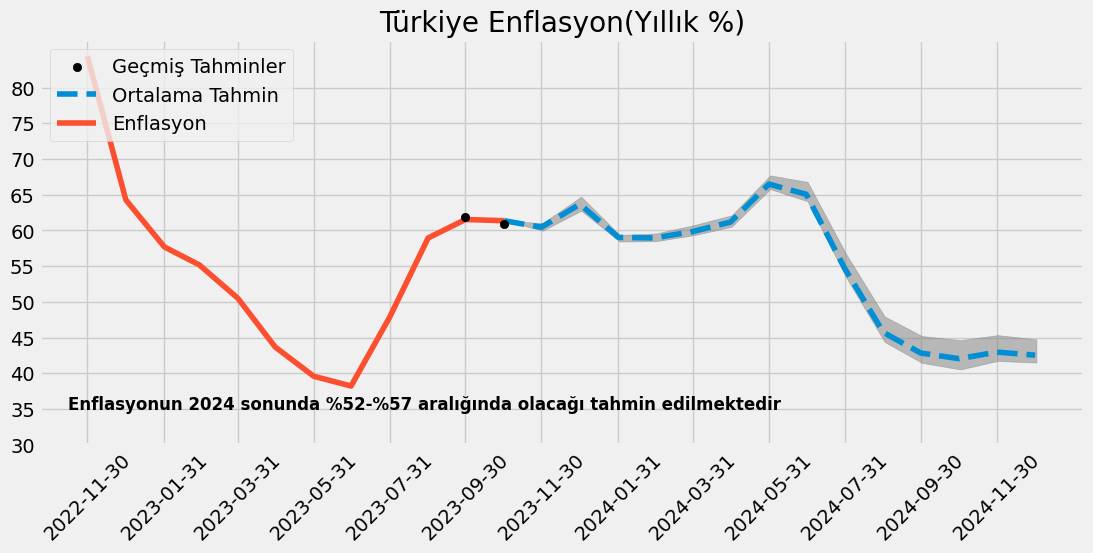

In [235]:
import matplotlib.dates as mdates  # datetime işlevlerini içe aktarın

# ...

plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,5))
plt.scatter(x=yıllıktahmin.index[199:201],y=[61.94,60.84],color='black',zorder=3,label='Geçmiş Tahminler')
plt.plot(yıllıktahmin["Ortalama"].iloc[200:215],'--',label="Ortalama Tahmin")
plt.plot(yıllıktahmin["Ortalama"].iloc[189:201],label="Enflasyon")
plt.fill_between(yıllıktahmin.iloc[200:216].index.strftime("%Y-%m"), yıllıktahmin["Maksimum"].iloc[200:216].shift(1), yıllıktahmin["Minimum"].iloc[200:216].shift(1), alpha=0.5, color='gray')
# Tarihi ekseni birimlerine dönüştürün
annotation_date = mdates.datestr2num('2024-06')

plt.text(annotation_date, 35, 'Enflasyonun 2024 sonunda %52-%57 aralığında olacağı tahmin edilmektedir', fontsize=12, color='black', horizontalalignment='right',fontweight='bold')

plt.xticks(yıllıktahmin.index[189:215][::2],rotation=45)
plt.yticks(np.arange(30,85,5))
plt.title("Türkiye Enflasyon(Yıllık %)")
plt.legend(loc=2)
plt.show()
